This notebook adresseses an employee scheduling problem involving multiple employees and tasks.

The objective studied is maximizing total number of tasks completed within available times of employees.

Each task can be assigned to at most one employee and preemption is not allowed. The duration of tasks is fixed (independent of the assigned employee) and it is assumed that each task can be assigned to any employee. Finally, employees are associated with availability start and end times.

In this notebook, we introduce **break times** i.e. lunch break. Each employee can take a certain duration of break within given time periods. 

The scheduling problem can be also viewed as machine scheduling problem in which employees correspond to machines.

In [1]:
import pandas as pd
import math
import numpy as np
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

# READ DATA

In [2]:
employeesTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Employees', header=0)
employeesTable = employeesTable.head(5) # select only 5 employees in order to have a small-sized problem 
employeesTable

,name,availability_start,availability_end,seniority,qualification,pay_rate
0,Anne,480,1020,11,1,25
1,Bethanie,480,1020,4,5,28
2,Betsy,480,1020,2,2,17
3,Cathy,480,1020,2,2,17
4,Cecilia,480,1020,9,5,38


In [3]:
tasksTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Tasks', header=0)
tasksTable = tasksTable.head(25) # select only 25 tasks in order to have a small-sized problem
tasksTable

,task_id,task_type,task_duration,required_nbr_of_employees
0,T001,Oncology,110,1
1,T002,Cardiac Care,80,1
2,T003,Anaesthesiology,60,1
3,T004,Pediatrics,70,1
4,T005,Oncology,120,1
5,T006,Cardiac Care,80,1
6,T007,Pediatrics,80,1
7,T008,Oncology,60,1
8,T009,Anaesthesiology,110,1
9,T010,Cardiac Care,30,1


# PREPARE DATA

Tuple data type can be used to retrieve certain values of each row of a dataframe (to be used in the optimization model). Each tuple set can correspond to an input table and the pandas method itertuples() returns a named tuple for each row of a DataFrame.

In [4]:
employeesT  = namedtuple("employeesT",['name', 'availabilityStart', 'availabilityEnd', 'seniority', 'qualification', 'payRate'])
employees  = [employeesT(*employees_row) for employees_row in employeesTable.itertuples(index=False)]
#employees 

In [5]:
tasksT  = namedtuple("tasksT",['taskId', 'taskType', 'taskDuration','requiredNbrOfEmployees'])
tasks  = [tasksT(*tasks_row) for tasks_row in tasksTable.itertuples(index=False)]
#tasks 

# CREATE A MODEL INSTANCE

In [6]:
from docplex.cp.model import *
mdl = CpoModel(name='employeeScheduling') 

# DEFINE DECISION VARIABLES

In [7]:
# define processing interval of each task at each employee
tasks_itv_vars = {} 
for e in employees:
    for t in tasks:
        tasks_itv_vars[t,e] = mdl.interval_var(start=(e.availabilityStart,e.availabilityEnd), end=(e.availabilityStart,e.availabilityEnd),optional=True, size=t.taskDuration, name="interval_task{}_employee{}".format(t.taskId,e.name))
        #print(tasks_itv_vars[t,e])

In [8]:
# define break interval for each employee
break_earliest_start = 660
break_latest_end = 900
break_duration = 60
break_itv_vars = {}
for e in employees:
    break_itv_vars[e] = mdl.interval_var(start=(break_earliest_start,break_latest_end), end=(break_earliest_start,break_latest_end), optional=True, size=break_duration, name="break_interval_employee{}".format(e.name))
    print (break_itv_vars[e])

break_interval_employeeAnne = intervalVar(optional, start=660..900, end=660..900, size=60)
break_interval_employeeBethanie = intervalVar(optional, start=660..900, end=660..900, size=60)
break_interval_employeeBetsy = intervalVar(optional, start=660..900, end=660..900, size=60)
break_interval_employeeCathy = intervalVar(optional, start=660..900, end=660..900, size=60)
break_interval_employeeCecilia = intervalVar(optional, start=660..900, end=660..900, size=60)


# EXPRESS OBJECTIVE FUNCTION

In [9]:
# minimize makespan
objective = mdl.max([mdl.end_of(tasks_itv_vars[t,e]) for t in tasks for e in employees])
mdl.add(mdl.minimize(objective)) 

# DEFINE CONSTRAINTS

In [10]:
# each task should be assigned to an employee
for t in tasks:
    mdl.add(mdl.sum([mdl.presence_of(tasks_itv_vars[t,e]) for e in employees]) == 1)

In [11]:
# ensure that if an employee has a task assigned, that employee should take a break
for e in employees:
    mdl.add(mdl.presence_of(break_itv_vars[e]) == mdl.any([mdl.presence_of(tasks_itv_vars[t,e]) for t in tasks]))

In [12]:
# no overlap constraint
for e in employees:
    mdl.add(mdl.no_overlap([tasks_itv_vars[t,e] for t in tasks] + [break_itv_vars[e]] )) 

# SOLVE THE MODEL

In [13]:
msol=mdl.solve(TimeLimit=60, execfile='C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio221\\cpoptimizer\\bin\\x64_win64\\cpoptimizer.exe')
print("Solution: ")
msol.print_solution()

 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 135 variables, 35 constraints
 ! TimeLimit            = 60
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 914.3 (before), 914.3 (after)
 !  . Memory usage      : 921.4 kB (before), 921.4 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        135                 -
 + New bound is 0
 ! Using iterative diving.
 *          1020       61  0.07s        1      (gap is 100.0%)
 *          1010      214  0.07s        1      (gap is 100.0%)
 *          1000      366  0.07s        1      (gap is 100.0%)
 *           990      426  0.07s        1      (gap is 100.0%)
 *           980      630  0.07s        1      (gap is 100.0%)
             980     1000          4    1     

# PREPARE OUTPUT TABLES

In [14]:
assignmentReport = [(e.name, t.taskId, t.taskDuration
                    ,msol.get_var_solution(tasks_itv_vars[t,e]).get_start(),msol.get_var_solution(tasks_itv_vars[t,e]).get_end()) 
                       for t in tasks for e in employees if msol.get_var_solution(tasks_itv_vars[t,e]).is_present()]
assignmentReport_df = pd.DataFrame(assignmentReport, columns=['Employee', 'Task', 'Duration','StartTime','EndTime'])
assignmentReport_df = assignmentReport_df.sort_values(by=['Employee', 'StartTime'], ascending=[True, True])
assignmentReport_df 

,Employee,Task,Duration,StartTime,EndTime
0,Anne,T001,110,480,590
10,Anne,T011,80,590,670
14,Anne,T015,120,730,850
4,Anne,T005,120,850,970
8,Bethanie,T009,110,480,590
17,Bethanie,T018,90,590,680
11,Bethanie,T012,70,740,810
6,Bethanie,T007,80,810,890
15,Bethanie,T016,70,890,960
23,Betsy,T024,60,480,540


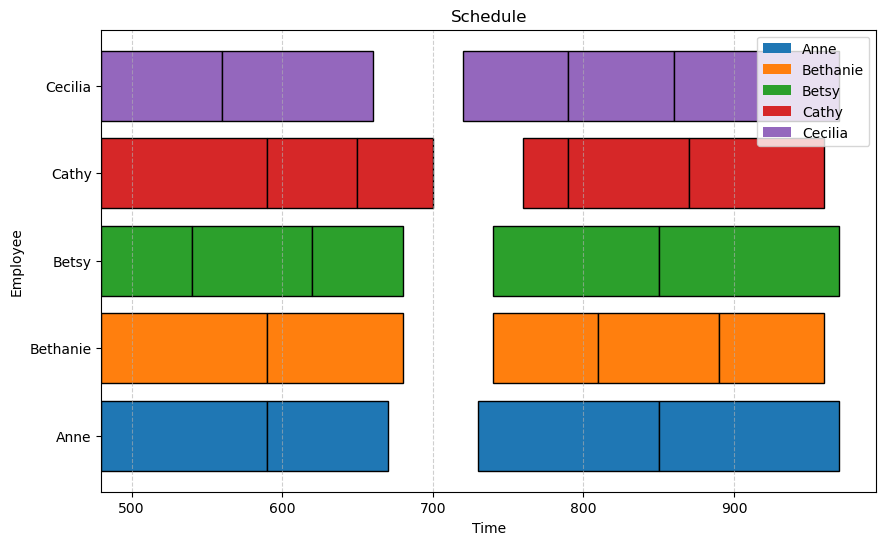

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

# Your data
df = assignmentReport_df

# Automatically define colors for resources using a colormap
cmap = plt.cm.get_cmap('tab10')  # You can choose other colormaps
colors = [cmap(i) for i in range(len(df['Employee'].unique()))]
resource_colors = dict(zip(df['Employee'].unique(), colors))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Gantt chart
for i, row in df.iterrows():
    start_time = row['StartTime']
    end_time = row['EndTime']
    task_duration = end_time - start_time
    ax.barh(row['Employee'], task_duration, left=start_time, color=resource_colors[row['Employee']], edgecolor='black', label="EEEE")

# Customize the chart
ax.set_xlabel('Time')
ax.set_ylabel('Employee')
ax.set_title('Schedule')

# Customize legend
legend_labels = [plt.Rectangle((0,0),1,1,fc=resource_colors[resource]) for resource in df['Employee'].unique()]
ax.legend(legend_labels, df['Employee'].unique())

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()